In [9]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [10]:
import sys
sys.path.append('../lib')

import XgbAdjustmentHelper as xgbhelper
from cv_helper import CVHelper
import sklearn_model_curve

In [11]:
munged_train_df = pd.read_csv('../data/offline/train.csv', index_col=0)
munged_test_df = pd.read_csv('../data/offline/test.csv', index_col=0)
y_train_df = pd.read_csv('../data/offline/y_train.csv', index_col=0)

X_train, X_test, y_train, y_test = train_test_split(munged_train_df.values, y_train_df.values, test_size=0.5, random_state=1729)
X_all_train = munged_train_df.values
y_all_train = y_train_df['y'].values

In [12]:
feature_names = munged_train_df.columns

In [13]:
# from hyperopt import hp
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# def objective(params):
#     print("Training with params : ")
#     print(params)
#     params['max_depth'] = np.int(params['max_depth'])
#     num_boost_round = 1000;
#     early_stopping_rounds = 50;
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dvalid = xgb.DMatrix(X_test)
#     # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
#     model = xgb.train(params, dtrain, num_boost_round = num_boost_round)
#     y_predict = model.predict(dvalid)
#     score = r2_score(y_test, y_predict)
#     loss = 1- score
#     print("\tScore {0}\n\n".format(score))
#     return {'loss': loss, 'status': STATUS_OK}

# def optimize():
#     space = {
#              'eta' : hp.uniform('eta', 0.005, 0.1),
#              'max_depth' : 4,
#              'min_child_weight' : hp.quniform('min_child_weight', 1, 9, 2),
#              'subsample' : hp.quniform('subsample', 0.8, 1, 0.05),
#              'gamma' : hp.quniform('gamma', 0, 0.5, 0.05),
#              'colsample_bytree' : hp.quniform('colsample_bytree', 0.8, 1, 0.05),
#              #'eval_metric': 'mlogloss',
#              'objective': 'reg:linear',
#              'silent' : 1,
#              }

#     best = fmin(objective, space, algo=tpe.suggest, max_evals=250)
#     return best;

# best = optimize()

In [14]:
# def ModelLearnRateSearch(params, learning_rates, num_bounds):
#     xgtrain = xgb.DMatrix(X_train, label=y_train)
#     xgb_model = xgb.XGBRegressor()
#     xgb_model.set_params(**params)
#     best_score = 0
#     best_params = {}
    
#     for lr in learning_rates:
        
#         params['learning_rate'] = lr
#         cvresult = xgb.cv(params, xgtrain, num_boost_round=num_bounds, nfold=5,
#                           metrics='rmse', early_stopping_rounds=50)
        
#         valid_round = cvresult.shape[0]
#         xgb_model.set_params(n_estimators = cvresult.shape[0], learning_rate = lr)
#         xgb_model.fit(X_train, y_train)
#         y_pred = xgb_model.predict(X_test)
#         score = r2_score(y_test, y_pred)
#         print("lr:%f  n_estimators:%d  score:%f\n"%(lr, valid_round, score))
#         if best_score < score:
#             best_score = score
#             best_params['n_estimators'] = valid_round
#             best_params['learning_rate'] = lr
            
#         print(xgb_model.get_params())
#     return best_score, best_params

In [28]:
xgb_model = xgb.XGBRegressor(n_estimators=600, max_depth=4, learning_rate=0.01, min_child_weight=8, colsample_bytree=0.85, subsample=0.92, seed=1729)
CVHelper.KFoldCV(xgb_model, 5, X_all_train, y_all_train, r2_score)

eval mean:0.567428 eval std:0.072424


(0.56742815183441719, 0.072423687927196459)

In [18]:
init_param = {
    'silent':True,
    'objective':'reg:linear',
    'seed':27,
    'max_depth':4,
}

adjust_param1 = {
    'learning_rate':[0.01, 0.005],
    'n_estimators':[500, 700, 1000],
}


adjust_param2 = {
    'min_child_weight':[1, 3, 8],
}

adjust_param3 = {
    'subsample':[i/100.0 for i in range(85, 105, 5)],
    'colsample_bytree':[i/100.0 for i in range(85, 105, 5)],
}

# adjust_param4 = {
#     'reg_alpha':[1e-5,1e-1],
# }


adjust_params = [adjust_param1, adjust_param2, adjust_param3]


xgb_model = xgb.XGBRegressor()
xgb_model.set_params(**init_param)

combine_param = dict(init_param)

for params in adjust_params:
    
    search = xgbhelper.ModelParamSearch(xgb_model, params, X_all_train, y_all_train, 'r2')
    xgb_model.set_params(**search.best_params_)
    combine_param.update(search.best_params_)



grid_scores
mean: 0.56617, std: 0.07509, params: {'learning_rate': 0.01, 'n_estimators': 500}
mean: 0.56490, std: 0.06858, params: {'learning_rate': 0.01, 'n_estimators': 700}
mean: 0.56079, std: 0.06682, params: {'learning_rate': 0.01, 'n_estimators': 1000}
mean: 0.15388, std: 0.13223, params: {'learning_rate': 0.005, 'n_estimators': 500}
mean: 0.51849, std: 0.09808, params: {'learning_rate': 0.005, 'n_estimators': 700}
mean: 0.56589, std: 0.07525, params: {'learning_rate': 0.005, 'n_estimators': 1000}

best_params
{'learning_rate': 0.01, 'n_estimators': 500}

best_score
0.5661732611882246

grid_scores
mean: 0.56617, std: 0.07509, params: {'min_child_weight': 1}
mean: 0.56539, std: 0.07504, params: {'min_child_weight': 3}
mean: 0.56693, std: 0.07611, params: {'min_child_weight': 8}

best_params
{'min_child_weight': 8}

best_score
0.566927683371629

grid_scores
mean: 0.56607, std: 0.07673, params: {'colsample_bytree': 0.85, 'subsample': 0.85}
mean: 0.56706, std: 0.07722, params: {'col

NameError: name 'ModelLearnRateSearch' is not defined

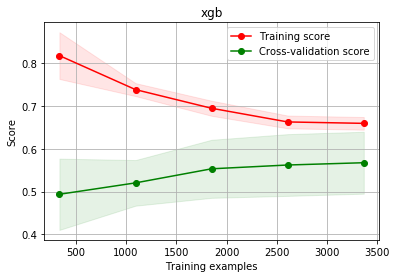

In [29]:
sklearn_model_curve.plot_learning_curve(xgb_model, 'xgb', X_all_train, y_all_train, cv=5)

In [30]:
xgb_model.fit(X_all_train, y_all_train)
y_pred = xgb_model.predict(munged_test_df.values)
output = pd.DataFrame({'id': munged_test_df.index, 'y': y_pred})
output.to_csv('../data/online/xgboost-pca-ica-grp-srp-6-14-1.csv', index=False)

In [22]:
y_pred

array([ 69.72631073,  83.14871979,  70.18686676, ...,  82.90158844,
        98.74907684,  83.40969849], dtype=float32)